<a href="https://colab.research.google.com/github/caglarmert/DI725/blob/main/DI725_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 725: Transformers and Attention-Based Deep Networks

## A Tutorial for Implementing Transformers in PyTorch

The purpose of this notebook is to introduce the transformers architecture, building different types of transformers and its adaptations to various tasks.

In this notebook, there will be three different tasks, suitable to demonstrate Encoder-Transformer, Decoder-Transformer and Encoder-Decoder Transformer architectures.

### Author:
* Ümit Mert Çağlar

# Introduction

## Attention Is All You Need

The paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), by Vaswani et al. changed the deep learning scene, starting with the NLP tasks, spanning almost all other aspects of deep learning studies, including vision and time series tasks. The emphasis of this paper is on attention and the carefully designed well-known and proven components. We will begin by examining the figure (provided by the author) and understand every component in the so-called transformer architecture.

---
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/attention_research_1.png?raw=true" width="300"/>
</div>

---
Just by observing the architecture we can spot some important aspects of the Transformer architecture.
* First, we have [embeddings](https://arxiv.org/abs/1608.05859) at the input and
output, these are required in many tasks, to transform data into high dimensional vectors.
* Second, we have [Positional Encoding](https://arxiv.org/pdf/1705.03122.pdf), which we require for the Transformer model to understand and relate the relative position of input and output tokens or embeddings.
* On the left-hand side, we have the Encoder structure, which is a stacked network (depicted with Nx), that has the subcomponents of a Multi-Head Attention and a Feed Forward Network.
* The attention mechanism, has Query, Key and Value (Q K V) as inputs, and all three of them are fed into the Multi-Head Attention block. This mechanism is the building pillar of Transformers, also highlighted by the authors:
 * *In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output.*
 * *An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.*
* We can also observe the Residual Connections and Layer Normalization block applied right after the attention and feed forward blocks. [Residual Connections](https://arxiv.org/abs/1512.03385) is an important factor that enables gradient flow in deeper networks. And [Layer Normalization](https://arxiv.org/abs/1607.06450) helps with the model training. Also the [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) mechanism is applied for all sub-layers and it helps with the training.
* Similarly on the right-hand side, we have another stacked architecture, but this time it is in the form of the Decoder structure.
* The first attention mechanism we observe is ***Masked*** Multi-Head Self-Attention. It is masked to make sure that model only observes and attends to the previous tokens or embeddings.
* The second attention mechanism in the Decoder architecture is Encoder-Decoder attention, or cross-attention layer. The keys and values come from the output of the Encoder stack while queries come from the first self-attention layer of the Decoder stack. With this cross-attention, decoder can attend over all positions in the input.
* The Feed Forward layers, that are present in both Encoder and Decoder stacks, are defined by two linear layers and a ReLU activation function.
* Finally, after all of the mechanisms and calculations, the generator that generates output probabilities is modeled by a linear layer and a softmax.


## Imports
In this part we import the required libraries. This part might be required to be operational on the Colab servers for later parts. It is advised to check the associated python requirements.txt, that is frozen at the time of preparation of this notebook, in case of any library or version error occurs while running this notebook. Mind that installing everything locally via pip install -r "requirements.txt" is not advised though, mainly because of the discrepancies between Colab and locally available machine.

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn, Tensor


The [torch](https://pytorch.org/) is a popular and diverse machine learning framework, enabling low level implementation (as low as it gets with Python anyway). The Neural Networks (nn) is a library within PyTorch that enables operations with neural network structures.

# Building a Transformer Architecture in PyTorch

## Building Blocks
Here we will try to build some building blocks that we will use in further parts.

### Part 1: Positional Encoding

Building the positional encoding can be observed from the implementation provided below.

#### Instructions
* Specify the PyTorch class that the positional encoder should subclass from.
* Initialize a positional encoding matrix for token positions in sequences up to max_length.
* Assign unique position encodings to the matrix pe by alternating the use of sine and cosine functions.
* Update the input embeddings tensor x to add position information about the sequence using the positional encodings matrix.


---

The Positional Encoding component is highlighted in the figure below, indicating its use, both in the Encoder, and the Decoder.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/PE_highlight.png?raw=true" width="300"/>
</div>

---




In the __init__ method, we first initialize the superclass nn.Module and then define the model's dimension d_model and the maximum sequence length max_length. We then create a zero matrix pe of size max_length by d_model to store the positional encodings.

Next, we calculate the positional encodings. We create a tensor position that contains the sequence positions and a tensor div_term that contains the division terms. The division terms are calculated using a formula that involves the natural logarithm of 10000 and the model's dimension. We then calculate the positional encodings by applying the sine function to the product of position and div_term for even indices and the cosine function for odd indices. The calculated positional encodings are then stored in the pe matrix.

In the forward method, we add the positional encodings to the input embeddings tensor x. We slice the pe matrix to match the size of x before adding. The updated tensor x is then returned.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/positional_encoding.PNG?raw=true" width="400"/>
</div>

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module. Inject some information about the relative or
    absolute position of the tokens in the sequence.The positional encodings
    have the same dimension as the embeddings, so that the two can be summed.
    Here, we use sine and cosine functions of different frequencies.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        dropout (float, optional): Dropout probability (default: 0.1).
        max_len (int, optional): Maximum sequence length (default: 5000).

    Attributes:
        dropout (torch.nn.Dropout): Dropout layer.
        pe (torch.Tensor): Positional encoding tensor.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = ## TODO the formula is given above, fill the code
        pe[:, 1::2] = ## TODO
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the positional encoding.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after adding positional encoding and applying dropout.
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

To demonstrate the operation of Positional Encoding, we can use the following code block:

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0, 5000)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7] ##TODO Change these values to your liking
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


example_positional()

alt.Chart(...)

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/positional_encoding_sine.png?raw=true" width="500"/>
</div>

### Part 2: Implementing multi-headed self-attention

The multi-headed attention mechanisms are highlighted in the Figure below:

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_headed_attention_highlighted.png?raw=true" width="300"/>
</div>




The multi-head attention is a form of scaled dot-product attention, calculated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/scaled_dot_product_attention_formula.PNG?raw=true" width="300"/>
</div>

Scaled dot-product attention demonstrated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/scaled_dot_product_attention.PNG?raw=true" width="300"/>
</div>

Multi-head attention calculated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_head_Attention_formula.PNG?raw=true" width="400"/>
</div>

Multi-head attention demonstrated as:
<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/multi_head_Attention.PNG?raw=true" width="300"/>
</div>


Building the multi-headed self-attention can be observed from the implementation provided below.

#### Instructions
* Split the sequence embeddings x across the multiple attention heads.
* Compute dot-product based attention scores between the project query and key.
* Normalize the attention scores to obtain attention weights.
* Multiply the attention weights by the values and linearly transform the concatenated outputs per head.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    A Multi-Head Attention layer as described in the paper "Attention is All You Need"
    (Vaswani et al., 2017).
    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.

    Attributes:
        num_heads (int): Number of attention heads.
        d_model (int): Dimensionality of the input and output feature vectors.
        head_dim (int): Dimensionality of each attention head.
        query_linear (torch.nn.Linear): Linear transformation layer for queries.
        key_linear (torch.nn.Linear): Linear transformation layer for keys.
        value_linear (torch.nn.Linear): Linear transformation layer for values.
        output_linear (torch.nn.Linear): Linear transformation layer for the final output.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads  # Dimension of each attention head

        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)
    def split_heads(self, x, batch_size):
        """
        Splits the sequence embeddings in `x` across the attention heads.

        Args:
            x (torch.Tensor): Input tensor to be split.
            batch_size (int): Batch size of the input tensor.

        Returns:
            torch.Tensor: Reshaped tensor with the sequence embeddings split across the attention heads.
        """
        # Split the sequence embeddings in x across the attention heads
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)

    def compute_attention(self, query, key, mask=None):
        """
        Computes dot-product attention scores.

        Args:
            query (torch.Tensor): Query tensor.
            key (torch.Tensor): Key tensor.
            mask (torch.Tensor, optional): Mask tensor to mask out certain positions.

        Returns:
            torch.Tensor: Attention weights.
        """
        # Compute dot-product attention scores
        
        ## use the "query" and "key.permute(1, 2, 0)" (key transpose) to calculate the attention score
        scores = # TODO
        if mask is not None:
            ## Apply mask with torch.masked_fill, don't forget to put an infinitesimally small "0"
            scores = ## TODO
        # Normalize attention scores into attention weights
        
        ## Apply softmax to the scores
        attention_weights = ## TODO
        return attention_weights

    def forward(self, query, key, value, mask=None):
        """
        Forward pass of the multi-head attention mechanism.

        Args:
            query (torch.Tensor): Query tensor.
            key (torch.Tensor): Key tensor.
            value (torch.Tensor): Value tensor.
            mask (torch.Tensor, optional): Mask tensor to mask out certain positions.

        Returns:
            torch.Tensor: Output tensor after applying multi-head attention mechanism.
        """
        batch_size = query.size(0)

        # Project queries, keys, and values to separate heads
        query = self.split_heads(self.query_linear(query), batch_size)
        key = self.split_heads(self.key_linear(key), batch_size)
        value = self.split_heads(self.value_linear(value), batch_size)

        # Compute attention weights
        attention_weights = ##TODO 

        # Multiply attention weights by values and linearly project concatenated outputs
        output = ##TODO
        output = output.view(batch_size, self.num_heads, -1, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.output_linear(output)

### Part 3: Post-attention feed-forward layer

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/feed_forward_highlighted.png?raw=true" width="300"/>
</div>



Feed-forward sublayer following multi-head self-attention for every encoder layer is built as an example below:



#### Instructions
* Specify in the __init__() method the sizes of the two linear fully connected layers.
* Apply a forward pass through the two linear layers, using the ReLU() activation in between.

In [ ]:
class FeedForwardSubLayer(nn.Module):
    """
    Feed-forward sub-layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        d_ff (int): Dimensionality of the intermediate hidden layer.

    Attributes:
        fc1 (torch.nn.Linear): First fully connected layer.
        fc2 (torch.nn.Linear): Second fully connected layer.
        relu (torch.nn.ReLU): ReLU activation function.
    """
    # Specify the two linear layers' input and output sizes
    def __init__(self, d_model, d_ff):
        """
        Initialize feed-forward sub-layer with two linear layers and ReLU activation.
        """
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = # TODO
        self.fc2 = # TODO
        self.relu = # TODO

    # Apply a forward pass
    def forward(self, x):
        """
        Forward pass of the feed-forward sub-layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the feed-forward sub-layer.
        """
        return # TODO 

## Encoder Transformer

Useful for tasks like classification, one of the most common application is  BERT (Bidirectional Encoder Representations from Transformers). Applies self-attention to the inputs to determine which parts are more useful for the task.


<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer.png?raw=true" width="150"/>
</div>



### Part 4: Encoder layer


Assembling a full encoder layer containing:

* A multi-headed self-attention mechanism.
* A feed-forward sublayer.
* A combined layer normalization and dropout to be applied after each of the above two stages.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer_norm_highlighted.png?raw=true" width="150"/>
</div>

In [ ]:
# Complete the initialization of elements in the encoder layer
class EncoderLayer(nn.Module):
    """
    Encoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attn (MultiHeadAttention): Multi-head self-attention mechanism.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize encoder layer with multi-head self-attention and feed-forward sub-layer.
        """
        super(EncoderLayer, self).__init__()
        # Multi-head self-attention
        self.self_attn = # TODO
        # Feedforward neural network
        self.feed_forward = # TODO
        self.norm1 = # TODO
        self.norm2 = # TODO
        self.dropout = # TODO

    def forward(self, x, mask):
        """
        Forward pass of the encoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            mask (torch.Tensor): Mask tensor for attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention and feed-forward sub-layer.
        """
        # Multi-head self-attention
        attn_output = # TODO
        x = self.norm1(# TODO)
        # Feedforward neural network
        ff_output = # TODO
        return self.norm2(# TODO)

### Part 5: Encoder transformer body and head

Implementing the transformer body, that is consisting of a stack of multiple encoder layers and a task specific transformer head that is used to process the encoder's hidden states.

Apart from the highlighted components, we have implemented everything so far. The linear layer followed by a softmax to output probabilities is the final implementation we will do in this section.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Encoder_only_transformer_head_highlighted.png?raw=true" width="150"/>
</div>


#### Instructions
* Define a stack of multiple encoder layers in the __init__() method.
* Complete the forward() method. Note that the process starts by converting the original sequence tokens in x into embeddings.
* Add final linear layer to project encoder results into raw classification outputs.
* Apply the necessary function to map raw classification outputs into log class probabilities.

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Transformer encoder module.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of encoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of encoder layers.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer encoder with embedding, positional encoding, and multiple encoder layers.
        """
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(# TODO)
        self.positional_encoding = PositionalEncoding(# TODO)
        # Define a stack of multiple encoder layers
        self.layers = nn.ModuleList([# TODO for _ in range(num_layers)])

    # Complete the forward pass method
    def forward(self, x, mask):
        """
        Forward pass of the transformer encoder.

        Args:
            x (torch.Tensor): Input tensor.
            mask (torch.Tensor): Mask tensor for attention mechanism.

        Returns:
            torch.Tensor: Output tensor after encoding.
        """
        # Apply input embedding    
        x = # TODO
        # Apply positional encoding
        x = # TODO
        for layer in self.layers:
            # Stack layers
            x = # TODO
        return x

class ClassifierHead(nn.Module):
    """
    Classifier head module.

    Args:
        d_model (int): Dimensionality of the input feature vectors.
        num_classes (int): Number of classes.

    Attributes:
        fc (torch.nn.Linear): Linear layer for classification.
    """
    def __init__(self, d_model, num_classes):
        """
        Initialize classifier head with linear layer.

        Args:
            d_model (int): Dimensionality of the input feature vectors.
            num_classes (int): Number of classes.
        """
        super(ClassifierHead, self).__init__()
        # Add linear layer for multiple-class classification
        self.fc = # TODO

    def forward(self, x):
        """
        Forward pass of the classifier head.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Log class probabilities upon raw outputs.
        """
        logits = self.fc(x[:, 0, :])
        # Obtain log class probabilities upon raw outputs
        return F.log_softmax(logits, dim=-1)

### Part 6: Testing the encoder transformer

A random and simple sequence will be used as an input to the encoder transformer. Obtaining the output (that is not even human-readable) without any errors is sufficient for this exercise.

The following components are adequate to form a full encoder transformer:
* PositionalEncoder
* MultiHeadAttention
* FeedForwardSublayer
* EncoderLayer
* TransformerEncoder
* ClassifierHead

Note: although a random input sequence and mask are being used here, in practice, the mask should correspond to the actual location of padding tokens in the input sequences to ensure all of them are the same length.

#### Instructions
* Instantiate the body and head of the encoder transformer.
* Complete the forward pass throughout the entire transformer body and head to obtain and print classification outputs.

In [ ]:
num_classes = 3
vocab_size = 10000
batch_size = 8
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
sequence_length = 64
dropout = 0.1

input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))

# input_sequence = torch.randint(0, vocab_size, (1, sequence_length))
# for i in range(1,batch_size):
#   input_sequence = torch.cat((input_sequence,(torch.randint(0, int(i*vocab_size/batch_size), (1, sequence_length)))))

mask = torch.randint(0, 2, (sequence_length, sequence_length))

# Instantiate the encoder transformer's body and head
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
classifier = ClassifierHead(d_model, num_classes)

# Complete the forward pass
output = encoder(input_sequence, mask)
classification_no_train = classifier(output)
print("Classification outputs for a batch of ", batch_size, "sequences:")
print(classification_no_train)

Classification outputs for a batch of  8 sequences:
tensor([[-1.4459, -0.8831, -1.0471],
        [-0.8046, -1.7915, -0.9519],
        [-0.9212, -1.2561, -1.1482],
        [-0.9247, -1.4208, -1.0165],
        [-1.4352, -1.1845, -0.7852],
        [-1.4846, -0.6909, -1.3009],
        [-1.1482, -1.4163, -0.8206],
        [-1.4330, -1.2273, -0.7586]], grad_fn=<LogSoftmaxBackward0>)


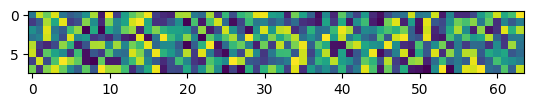

In [ ]:
plt.imshow(input_sequence.detach().numpy())

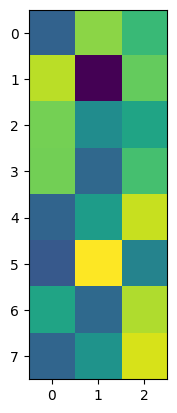

In [ ]:
plt.imshow(classification_no_train.detach().numpy())

The output is random, as expected from the random initialization of the learnable parameters. For each element in the batch, we have a row and columns corresponding to the number of classes we have defined.

Now we can prepare a very basic training structure. Note that this training will not be plausible for any real-world example, but it is still important to follow for how to adapt the power of PyTorch. Changing parameters that define the transformer model and the task itself is encouraged here.

In [ ]:
# Define your model
num_classes = 3
vocab_size = 10000
batch_size = 8
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
sequence_length = 64
dropout = 0.1

#input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))
#mask = torch.randint(0, 2, (sequence_length, sequence_length))

encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
classifier = ClassifierHead(d_model, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = encoder(input_sequence, mask)
    classification = classifier(output)

    # Assuming you have ground truth labels as 'targets'
    targets = torch.randint(0, num_classes, (batch_size,))
    loss = criterion(classification, targets)

    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# After training, you can print the classification results
print("Classification outputs for a batch of", batch_size, "sequences:")
print(classification)

Epoch [1/10], Loss: 1.2837
Epoch [2/10], Loss: 3.5493
Epoch [3/10], Loss: 9.9661
Epoch [4/10], Loss: 6.6045
Epoch [5/10], Loss: 4.2706
Epoch [6/10], Loss: 1.7698
Epoch [7/10], Loss: 1.5776
Epoch [8/10], Loss: 1.7213
Epoch [9/10], Loss: 1.8039
Epoch [10/10], Loss: 1.8295
Classification outputs for a batch of 8 sequences:
tensor([[-2.1471, -2.3153, -0.2428],
        [-2.2620, -2.4823, -0.2079],
        [-2.1690, -2.4683, -0.2219],
        [-2.2322, -2.4408, -0.2162],
        [-2.0167, -2.5945, -0.2329],
        [-2.2177, -2.4163, -0.2208],
        [-2.2602, -2.7448, -0.1846],
        [-2.2154, -2.6419, -0.1989]], grad_fn=<LogSoftmaxBackward0>)


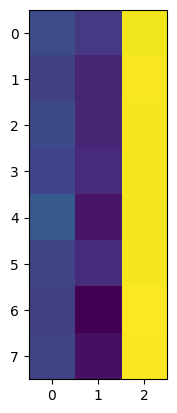

In [ ]:
plt.imshow(classification.detach().numpy())

We have not arranged any viable feature for the input to the transformer model, so it is not possible to distinguish any of the inputs. However, we can observe that three classes will (somewhat) align after some training.

Note: Although a random input sequence and mask are being used here, in practice, the mask should correspond to the actual location of padding tokens in the input sequences to ensure all of them are the same length.

We will come back to this mask again later to compare it with a causal mask.

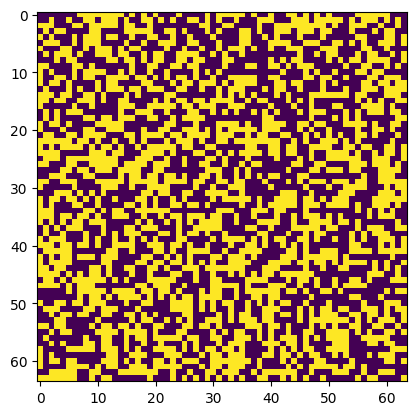

In [ ]:
plt.imshow(mask)

## Decoder Transformer
Used for tasks like text generation, where the model generates text for a given input or prompt. Text generation occurs as a word at a time and conditions on itself (previously generated content) to generate new ones. GPT-3 (Generative Pre-trained Transformer 3) is a well-known Decoder only Transformer.

<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/decoder_only_transformer.png?raw=true" width="150"/>
</div>




### Part 7: Decoder Layer

The encoder layer in part 4 is built similarly; what is the difference between these two structures?


#### Instructions
* A multi-headed self-attention mechanism.
* A feed-forward sublayer.
* Normalization and dropout are to be applied.

In [ ]:
class DecoderLayer(nn.Module):
    """
    Decoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attention (MultiHeadAttention): Multi-head self-attention mechanism.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """

    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize decoder layer with multi-head self-attention and feed-forward sub-layer.
        """
        super(DecoderLayer, self).__init__()
        # Multi-head self-attention
        self.self_attention = # TODO
        self.norm1 = # TODO
        # Feedforward neural network
        self.feed_forward = # TODO
        self.norm2 = # TODO
        self.dropout = # TODO


    def forward(self, x, self_mask):
        """
        Forward pass of the decoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            self_mask (torch.Tensor): Mask tensor for self-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention and feed-forward sub-layer.
        """
        # Multi-head self-attention
        attention_output = # TODO
        x = # TODO
        x = # TODO

        # Feedforward neural network
        ff_output = # TODO
        x = # TODO
        x = # TODO

        return x


### Part 8: Building a decoder body and head

A high-level structure for a decoder-only transformer will be implemented in this exercise. Unlike the encoder transformer, the model body and head are not separated in the decoder transformer. Instead, the decoder transformer contains the model head and body. The model body is a stack of decoder layers.

#### Instructions
* Add the linear layer for the model head inside the TransformerDecoder class.
* Apply the last stage of the forward pass through the model head.

In [ ]:
class TransformerDecoderOnly(nn.Module):
    """
    Transformer decoder-only module for next-element prediction.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of decoder layers.
        fc (torch.nn.Linear): Linear layer for next-word prediction.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer decoder-only with embedding, positional encoding, decoder layers, and linear layer for next-element prediction.
        """
        super(TransformerDecoderOnly, self).__init__()
        self.embedding = # TODO
        self.positional_encoding = # TODO
        self.layers = nn.ModuleList([# TODO for _ in range(num_layers)])

        # Add a linear layer (head) for next-word prediction
        self.fc = # TODO

    def forward(self, x, self_mask):
        """
        Forward pass of the transformer decoder-only for next-word prediction.

        Args:
            x (torch.Tensor): Input tensor.
            self_mask (torch.Tensor): Mask tensor for self-attention mechanism.

        Returns:
            torch.Tensor: Log probabilities of the next words in the vocabulary.
        """
        x = # TODO
        x = # TODO
        for layer in self.layers:
            x = layer(x, self_mask)

        # Apply the forward pass through the model head
        x = # TODO
        return # TODO

### Part 9: Testing the decoder transformer

A random and simple sequence will be used as an input to the decoder transformer. Obtaining the output without any errors is sufficient for this exercise.

The following components are adequate to form a full decoder transformer:
* PositionalEncoder
* MultiHeadAttention
* FeedForwardSublayer
* DecoderLayer
* TransformerDecoder

#### Instructions
* Implement the decoder transformer with methods and classes defined before.
* Complete the forward pass throughout the entire transformer body and head to obtain and print outputs.

In [ ]:
vocab_size = 8
batch_size = 8
d_model = 16
num_heads = 1
num_layers = 6
d_ff = 32
sequence_length = 8
dropout = 0.1

input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)

# Create a triangular attention mask for causal attention
self_attention_mask = (1 - torch.triu(torch.ones(1, sequence_length, sequence_length), diagonal=1)).bool()
print("The input sequence")
print(input_sequence)



The input sequence
tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7]])


In [ ]:
# Instantiate the decoder transformer
decoder = TransformerDecoderOnly(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

output = decoder(input_sequence, self_attention_mask)
print("Shape of our output:")
print(output.shape)
print("The first output we get:")
print(output[0])


Shape of our output:
torch.Size([8, 8, 8])
The first output we get:
tensor([[-1.8165, -1.7808, -2.5037, -3.3011, -2.7044, -1.8818, -1.9559, -1.6627],
        [-2.4807, -2.3567, -2.2225, -3.0499, -2.5416, -1.3380, -2.0216, -1.6485],
        [-1.9305, -2.3686, -2.0409, -3.0417, -2.7439, -1.5541, -2.7420, -1.4127],
        [-1.9213, -2.1896, -1.6013, -3.1951, -2.4969, -1.7887, -2.6118, -1.7367],
        [-1.6177, -1.8508, -2.3247, -3.0555, -2.6899, -1.8568, -2.0845, -1.8892],
        [-2.3183, -2.0023, -2.7549, -3.2174, -2.8442, -1.4006, -2.1964, -1.3982],
        [-1.5329, -1.4114, -2.6585, -3.4570, -3.3868, -1.8595, -2.1438, -2.0256],
        [-1.6161, -1.8129, -2.5816, -2.8837, -3.2749, -1.6019, -2.1123, -1.9224]],
       grad_fn=<SelectBackward0>)


The triangular mask defined here is the causal mask that prohibits the decoder from observing the "future" or cheating. For the first element in the sequence, the decoder can only observe the first element; for the second, the second and the first; and for the nth element, the decoder can only observe elements (tokens) up to the nth element, basically the last generated element and all previous ones.

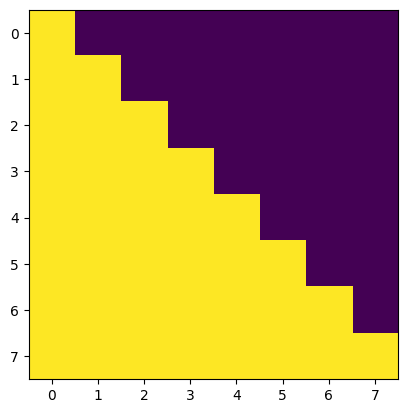

In [ ]:
plt.imshow(self_attention_mask[0])

Let's modify the decoder-transformer to be able to ouput integer values for a given sequence:

In [ ]:
class TransformerDecoderOnly(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        super(TransformerDecoderOnly, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model = d_model, max_len = max_sequence_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Add a linear layer (head) for next-word prediction
        self.fc = nn.Linear(d_model, vocab_size)
        self.fc2 = nn.Linear(vocab_size, 1)

    def forward(self, x, self_mask):

        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, self_mask)

        # Apply the forward pass through the model head
        x = self.fc2(self.fc(x)) # <-----
        return x # <-----

vocab_size = 8
batch_size = 8
d_model = 16
num_heads = 1
num_layers = 1
d_ff = 16
sequence_length = 8
dropout = 0.1
input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)
input_sequence = input_sequence.long()
self_attention_mask = (1 - torch.triu(torch.ones(1, sequence_length, sequence_length), diagonal=1)).bool()

decoder = TransformerDecoderOnly(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.01)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = decoder(input_sequence, self_attention_mask)

    # Flatten the output and target tensors to have a consistent shape
    output_flat = output.view(-1)
    target_flat = input_sequence.view(-1)
    # Compute the loss
    loss = criterion(output_flat, target_flat.float())

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    # Print the loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/30], Loss: 21.65715789794922
Epoch [2/30], Loss: 18.709980010986328
Epoch [3/30], Loss: 16.24869155883789
Epoch [4/30], Loss: 14.108474731445312
Epoch [5/30], Loss: 12.15359878540039
Epoch [6/30], Loss: 10.517559051513672
Epoch [7/30], Loss: 9.112133026123047
Epoch [8/30], Loss: 7.572569847106934
Epoch [9/30], Loss: 6.415394306182861
Epoch [10/30], Loss: 5.534232139587402
Epoch [11/30], Loss: 4.8613481521606445
Epoch [12/30], Loss: 4.333537578582764
Epoch [13/30], Loss: 3.768571138381958
Epoch [14/30], Loss: 2.8923428058624268
Epoch [15/30], Loss: 2.962461471557617
Epoch [16/30], Loss: 2.2327513694763184
Epoch [17/30], Loss: 1.966929316520691
Epoch [18/30], Loss: 1.8678109645843506
Epoch [19/30], Loss: 2.0587801933288574
Epoch [20/30], Loss: 2.022169589996338
Epoch [21/30], Loss: 2.1177818775177
Epoch [22/30], Loss: 1.5497159957885742
Epoch [23/30], Loss: 1.0339434146881104
Epoch [24/30], Loss: 0.9906540513038635
Epoch [25/30], Loss: 0.60573410987854
Epoch [26/30], Loss: 0.698

In [ ]:
output_flat.int()

tensor([1, 1, 2, 3, 4, 4, 4, 6, 0, 1, 1, 2, 3, 3, 6, 5, 1, 0, 2, 3, 4, 4, 5, 5,
        0, 0, 1, 3, 2, 4, 6, 6, 1, 1, 1, 1, 3, 4, 6, 6, 0, 1, 2, 3, 4, 3, 6, 6,
        1, 1, 2, 3, 4, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 5], dtype=torch.int32)

This is a very dummy and simple way of adapting a transformer model to requirements. It is recommended to adapt the transformer further, and output a sequence just like the input sequence (0,1,2,3,...) or output the next element for a given sequence (input: 0,1,2, output: **3**)

## Encoder-Decoder Transformer
It is useful for translation tasks where a given input text is required to be translated into an output in a target language. T5 (Text-to-Text Transfer Transformer) is a well-known encoder-decoder transformer that can also do summarization, question answering, and translation.

### Part 10: Incorporating cross-attention in a decoder

In an encoder-decoder transformer, decoder layers incorporate two attention mechanisms: the causal attention inherent to any transformer decoder and a cross-attention that integrates source sequence information processed by the encoder with the target sequence information being processed through the decoder.


<div>
<img src="https://github.com/caglarmert/DI725/blob/main/src/Cross_attention.png?raw=true" width="300"/>
</div>


Modify the DecoderLayer class to incorporate this two-fold attention scheme.

#### Instructions
* Initialize the two attention mechanisms used in an encoder-decoder transformer's decoder layer: causal (masked) self-attention and cross-attention.
* Pass the necessary input arguments (query, key, values, and mask) to the two attention stages in the forward pass.

In [ ]:
class DecoderLayer(nn.Module):
    """
    Decoder layer module.

    Args:
        d_model (int): Dimensionality of the input and output feature vectors.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.

    Attributes:
        self_attn (MultiHeadAttention): Multi-head self-attention mechanism.
        cross_attn (MultiHeadAttention): Multi-head cross-attention mechanism.
        feed_forward (FeedForwardSubLayer): Feed-forward sub-layer.
        norm1 (torch.nn.LayerNorm): Layer normalization for the first sub-layer.
        norm2 (torch.nn.LayerNorm): Layer normalization for the second sub-layer.
        norm3 (torch.nn.LayerNorm): Layer normalization for the third sub-layer.
        dropout (torch.nn.Dropout): Dropout layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Initialize decoder layer with multi-head self-attention, multi-head cross-attention, and feed-forward sub-layer.

        Args:
            d_model (int): Dimensionality of the input and output feature vectors.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer, self).__init__()

        # Initialize the causal (masked) self-attention and cross-attention
        self.self_attn = # TODO
        self.cross_attn = # TODO
        self.feed_forward = # TODO
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_mask, encoder_output, cross_mask):
        """
        Forward pass of the decoder layer.

        Args:
            x (torch.Tensor): Input tensor.
            causal_mask (torch.Tensor): Mask tensor for causal self-attention mechanism.
            encoder_output (torch.Tensor): Encoder output tensor.
            cross_mask (torch.Tensor): Mask tensor for cross-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after applying multi-head self-attention, multi-head cross-attention, and feed-forward sub-layer.
        """
        # Pass the necessary arguments to the causal self-attention and cross-attention
        self_attn_output = # TODO
        x = # TODO
        cross_attn_output = # TODO
        # (query, key, values, and mask)
        x = # TODO
        ff_output = # TODO
        x = # TODO
        return x

### Part 11: Defining Decoder Layer

The decoder layer is to be built in this part. What is the main difference of this part and part 7?


#### Instructions
* A multi-headed self-attention mechanism.
* A feed-forward sublayer.
* Normalization and dropout are to be applied.

In [ ]:
class TransformerDecoder(nn.Module):
    """
    Transformer decoder module.

    Args:
        vocab_size (int): Vocabulary size.
        d_model (int): Dimensionality of the input and output feature vectors.
        num_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        d_ff (int): Dimensionality of the intermediate hidden layer in the feed-forward sub-layer.
        dropout (float): Dropout probability.
        max_sequence_length (int): Maximum sequence length for positional encoding.

    Attributes:
        embedding (torch.nn.Embedding): Embedding layer.
        positional_encoding (PositionalEncoding): Positional encoding layer.
        layers (torch.nn.ModuleList): List of decoder layers.
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        """
        Initialize transformer decoder with embedding, positional encoding, and decoder layers.
        """
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model = d_model, max_len = max_sequence_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, causal_mask, encoder_output, cross_mask):
        """
        Forward pass of the transformer decoder.

        Args:
            x (torch.Tensor): Input tensor.
            causal_mask (torch.Tensor): Mask tensor for causal self-attention mechanism.
            encoder_output (torch.Tensor): Encoder output tensor.
            cross_mask (torch.Tensor): Mask tensor for cross-attention mechanism.

        Returns:
            torch.Tensor: Output tensor after decoding.
        """
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, causal_mask, encoder_output, cross_mask)
        return x

### Part 12: Trying out an encoder-decoder transformer

Encoder-decoder transformers can be used for translation tasks. Here we are going to demonstrate the ability of adapting a transformer for this specific task. Basically, we are going to feed a sequence and expect to obtain another sequence. We can think of this as sentence in the source language as the input and in the target language as the output. For this task, we are going to have an input sequence, that will be ***translated*** into a target sequence, this translation is effectively used in image domain as well. We can think of translation as a task that maps certain values to target values.

Remember that we are only testing a yet-to-be-trained transformer architecture, hence the use of random input sequences.

The following components are required to form a full encoder-decoder transformer:
* MultiHeadAttention
* FeedForwardSubLayer
* PositionalEncoding
* EncoderLayer
* DecoderLayer
* TransformerEncoder
* TransformerDecoder

#### Instructions

* Create a batch of random input sequences of size batch_size X sequence_length.
* Instantiate the two transformer bodies using the appropriate class names.
* Pass the necessary masks as arguments to the encoder and the decoder for their underlying attention mechanisms; each mask argument should be added in the same order they are utilized inside the encoder or decoder layer.

In [ ]:
vocab_size = 8
batch_size = 4
d_model = 8
num_heads = 2
num_layers = 2
d_ff = 16
sequence_length = 8
dropout = 0.1


# Create a batch of random input sequences
#input_sequence = torch.randint(0, vocab_size, (batch_size, sequence_length))

input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)

padding_mask = torch.randint(0, 2, (sequence_length, sequence_length))
causal_mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)

# Instantiate the two transformer bodies
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
decoder = TransformerDecoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

# Pass the necessary masks as arguments to the encoder and the decoder
encoder_output = encoder(input_sequence, padding_mask)
decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
print("Batch's output shape: ", decoder_output.shape)

Batch's output shape:  torch.Size([4, 8, 8])


Let's check the causal mask for the Encoder-Decoder Transformer

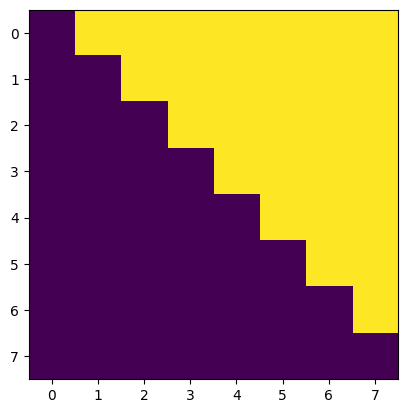

In [ ]:
plt.imshow(causal_mask)

As we have seen in Decoder-Transformer, the causal mask is again a diagonal matrix that disables the capability of the Decoder part to see the future elements in a sequence.

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
target_sequence = input_sequence.roll(2)
print("Input sequence")
print(input_sequence[0])
print("Target sequence (Translated)")
print(target_sequence[0])
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    encoder_output = encoder(input_sequence, padding_mask)
    decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
    loss = criterion(decoder_output.view(-1, vocab_size), target_sequence.view(-1))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print("Batch's output shape: ", decoder_output.shape)
print("Output sequence:")

Input sequence
tensor([0, 1, 2, 3, 4, 5, 6, 7])
Target sequence (Translated)
tensor([6, 7, 0, 1, 2, 3, 4, 5])
Epoch [1/10], Loss: 2.697746992111206
Epoch [2/10], Loss: 2.659696578979492
Epoch [3/10], Loss: 2.6397345066070557
Epoch [4/10], Loss: 2.6122608184814453
Epoch [5/10], Loss: 2.5470809936523438
Epoch [6/10], Loss: 2.5937390327453613
Epoch [7/10], Loss: 2.6101434230804443
Epoch [8/10], Loss: 2.595712900161743
Epoch [9/10], Loss: 2.3930373191833496
Epoch [10/10], Loss: 2.5007448196411133
Batch's output shape:  torch.Size([4, 8, 8])
Output sequence:


The decoder output is shown below. What is missing from this implementation? Where is the output we desire?

In [ ]:
print(decoder_output[0])

tensor([[ 0.1518,  1.1863, -1.7123,  0.2617,  1.2484, -0.6863, -1.0119,  0.5562],
        [ 1.4876, -0.4550, -1.3039,  1.5357, -0.2532,  0.3253, -1.0567, -0.2778],
        [ 0.4609,  0.5789, -2.2267,  1.2172, -0.3164,  0.4919, -0.5744,  0.3647],
        [-0.6704, -0.1011,  0.4295,  0.3604, -0.2925,  2.0598, -1.6335, -0.1625],
        [-1.4510,  0.3150, -0.6059,  0.8028,  1.6131,  0.3211, -1.3235,  0.3137],
        [-1.0165, -0.5673, -1.1851,  1.0282,  0.1646,  1.2266, -0.9146,  1.2520],
        [-1.6267,  1.5212,  0.3601,  0.7630, -0.0149,  0.1874, -1.4380,  0.2322],
        [ 0.4781, -0.0560, -1.0289,  1.1301, -0.5303,  0.8180, -1.8094,  0.9944]],
       grad_fn=<SelectBackward0>)


Hint: we have missed a final touch for the encoder-decoder transformer architecture, which is the final head on the decoder side. By changing it we can adapt our architecture to many different problems.

In [ ]:
class TranslatorHead(nn.Module):
    def __init__(self, d_model, sequence_length):
        super(TranslatorHead, self).__init__()
        # Add linear layer for translation
        self.fc = nn.Linear(d_model, sequence_length)
        self.fc2 = nn.Linear(sequence_length, 1)

    def forward(self, x):
        return self.fc2(self.fc(x))

In [ ]:
vocab_size = 8
batch_size = 4
d_model = 8
num_heads = 2
num_layers = 4
d_ff = 16
sequence_length = 8
dropout = 0.2

input_sequence = torch.arange(0, sequence_length).unsqueeze(0).repeat(batch_size, 1)

padding_mask = torch.randint(0, 2, (sequence_length, sequence_length))
causal_mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)

# Instantiate the two transformer bodies
encoder = TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
decoder = TransformerDecoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)
translator_head = TranslatorHead(d_model, vocab_size)

# Pass the necessary masks as arguments to the encoder and the decoder
encoder_output = encoder(input_sequence, padding_mask)
decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
print("Batch's output shape: ", decoder_output.shape)
translator_output = translator_head(decoder_output)
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1)
target_sequence = input_sequence.roll(1)
print("Input sequence")
print(input_sequence[0])
print(input_sequence.shape)
print("Target sequence (Translated)")
print(target_sequence[0])
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    optimizer.zero_grad()
    encoder_output = encoder(input_sequence, padding_mask)
    decoder_output = decoder(input_sequence, causal_mask, encoder_output, padding_mask)
    translator_output = translator_head(decoder_output)
    loss = criterion(translator_output.view(-1), target_sequence.view(-1).float())
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

print("Output shape: ", translator_output.shape)
print("Output sequence:")
print(translator_output.view(-1).int())


Batch's output shape:  torch.Size([4, 8, 8])
Input sequence
tensor([0, 1, 2, 3, 4, 5, 6, 7])
torch.Size([4, 8])
Target sequence (Translated)
tensor([7, 0, 1, 2, 3, 4, 5, 6])
Epoch [1/20], Loss: 15.305901527404785
Epoch [2/20], Loss: 8.699307441711426
Epoch [3/20], Loss: 5.636639595031738
Epoch [4/20], Loss: 5.317410469055176
Epoch [5/20], Loss: 7.022207260131836
Epoch [6/20], Loss: 7.324475288391113
Epoch [7/20], Loss: 6.874665260314941
Epoch [8/20], Loss: 5.710813045501709
Epoch [9/20], Loss: 5.530500888824463
Epoch [10/20], Loss: 5.394636154174805
Epoch [11/20], Loss: 5.2456889152526855
Epoch [12/20], Loss: 5.221963405609131
Epoch [13/20], Loss: 5.68686580657959
Epoch [14/20], Loss: 5.580173492431641
Epoch [15/20], Loss: 5.707486152648926
Epoch [16/20], Loss: 5.3308868408203125
Epoch [17/20], Loss: 5.0327606201171875
Epoch [18/20], Loss: 5.468961715698242
Epoch [19/20], Loss: 5.361144542694092
Epoch [20/20], Loss: 5.461234092712402
Output shape:  torch.Size([4, 8, 1])
Output sequence

# Conclusion

In this exercise, we have seen the vanilla transformer from the paper Attention Is All You Need by Vaswani et al. and implemented its components from scratch with PyTorch. Experimenting with different hyperparameters that define the deep learning model architecture or training structure is highly recommended as an extra follow-up exercise!

We have seen three different implementations of transformers, namely the Encoder-Transformer, Decoder-Transformer and Encoder-Decoder (Vanilla) Transformer. We built them with basic building blocks and tested their input-output pipeline. We have also tested a very brief dummy training example that demonstrates the learning capability to some extent.

# Questions
1. Why do we implement PositionalEncoding in part 1?
1. How do we feed Querry, Key, and Value to the multi-head attention blocks?
1. What is the purpose of the mask (self_attention_mask) defined in Part 9?
1. Why do we use split heads in the attention mechanism?
1. What is the difference between self-attention and cross-attention?
1. Where exactly is the cross-attention mask applied in the vanilla transformer architecture?
1. Which of these (Q, K, and V) is supplied from the Encoder to the cross-attention in the Encoder-Decoder transformer? And which from the decoder's attention?
1. Why are we shifting outputs to the right (in the vanilla Transformer architecture)?
1. What can we do to improve the training process in Parts 6, 9, and 12? Which mechanisms and architecture alterations can enhance the results?
1. What are some possible use-case scenarios for Encoder-only Transformer, Decoder-only Transformer and Encoder-Decoder Transformer?



# References
References and further tutorials to check out:
1. The paper, Attention is all you need, the transformer paper that introduced a whole new way of approaching deep learning: https://arxiv.org/abs/1706.03762
1. A solid blog that explains the Transformer architecture and its sub components: https://buomsoo-kim.github.io/attention/2020/04/19/Attention-mechanism-17.md/
1. Training a Transformer model, with a real dataset: https://buomsoo-kim.github.io/attention/2020/04/20/Attention-mechanism-18.md/
1. Further explanations on top of previous posts https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/
1. Another Transformer tutorial: https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
1. The annotated Transformer, updated for newer version of PyTorch, an excellent guide that uses the original authors sentences and implement everything (just like we did in this tutorial): https://nlp.seas.harvard.edu/annotated-transformer/
1. PyTorch's documentation for Transformers and other helper libraries: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
1. Dive into Deep Learning tutorial that uses their version of libraries, a different take on Transformer model implementation: https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html

